In [58]:
import numpy as np
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_product, matrix_transpose, rotation_matrix
from astropy.io import fits
import pickle 
import scipy.interpolate as scint
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import gala.coordinates as gc
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from astropy_healpix import HEALPix
import time
#import healpy as hp
#import healpix_util as hu

In [40]:
class ArbitraryPoleFrame(coord.BaseCoordinateFrame):
    
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential:[
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }
    
    pole = coord.CoordinateAttribute(frame=coord.ICRS)    
    roll = coord.QuantityAttribute(default=0*u.degree)

In [41]:
@frame_transform_graph.transform(coord.DynamicMatrixTransform, coord.ICRS, ArbitraryPoleFrame)
def icrs_to_arbpole(icrs_coord, arbpole_frame):
    
    roll = arbpole_frame.roll
    pole = arbpole_frame.pole
    
    # Align z(new) with direction to M31
    mat1 = rotation_matrix(-pole.dec, 'y')
    mat2 = rotation_matrix(pole.ra, 'z')
    mat3 = rotation_matrix(roll, 'z')
    mat4 = rotation_matrix(90*u.degree, 'y')
    R = matrix_product(mat4, mat1, mat2, mat3)
    
    return R

@frame_transform_graph.transform(coord.DynamicMatrixTransform, ArbitraryPoleFrame, coord.ICRS)
def arbpole_to_icrs(arbpole_coord, icrs_frame):
    return matrix_transpose(icrs_to_arbpole(None, arbpole_coord))

In [27]:
def plotFootprint(x, y, filename, nbins=250):
    fig2, axes = plt.subplots()#1, 3, figsize=(15, 5)) 
    H, xedges, yedges = np.histogram2d(x, y, bins=(nbins, nbins))
    axes.pcolormesh(xedges, yedges, H.T, norm=mpl.colors.LogNorm(vmin=10, vmax=1000))
    plt.ylabel('phi2')
    plt.xlabel('phi1')
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(10,10)
    fig.savefig(filename, rasterized=True)

In [77]:
def plotPMdiff(phi1min, phi1max, filename='sag_pm'):
    minstars = 100.
    minFracBackground = 0.5
    plotSNthreshold = 5.
    detectionThreshold = 5.
    
    phi1min = phi1min #80*u.deg #-60.*u.deg #105*u.deg
    phi1max = phi1max #120*u.deg #-20.*u.deg #115*u.deg
    phi2min = -0.5*u.deg
    phi2max = 0.5*u.deg

    phi2max_b = 5.0*u.deg
    phi2min_b = 0.5*u.deg

    dphi1 = phi1max - phi1min
    dphi2 = phi2max - phi2min
    dphi2_b = phi2max_b - phi2min_b

    areaSignal = dphi1*dphi2
    areaBackground = (dphi1*dphi2_b)*2.

    dpm1 = 15.#*u.mas/u.yr
    dpm2 = 5.#*u.mas/u.yr
    deltapm = 1.0#*u.mas/u.yr

    deltaphi = 0.1

    signal_edges_pm1 = [-dphi1/2., dphi1/2.]
    signal_edges_pm2 = [-dphi2/2., dphi2/2.]
    background_edges_pm1 = [-dphi1/2., dphi1/2.]
    background_edges_pm2 = [-(dphi2_b + dphi2)/2., -dphi2/2.]
    backgtound_edges_pm2 = [dphi2/2., (dphi2_b+dphi2)/2.]

    signal_indices = (phi1 >= phi1min) & (phi1 <= phi1max) & \
                     (phi2 >= phi2min) & (phi2 <= phi2max) #& colorCut & magCut

    #check that there are more then 100 stars in the signal sample
    if np.sum(signal_indices) < minstars: 
        return None, None
    else:
        background_indices = (phi1 >= phi1min) & (phi1 <= phi1max) & \
                             np.logical_or((phi2 > phi2min_b) & (phi2 <= phi2max_b),
                                           (phi2 >= -phi2max_b) & (phi2 <= -phi2min_b)) #& colorCut & magCut

        phi1_edges = np.arange(phi1min.value, phi1max.value+000.1, deltaphi)
        phi2_edges = np.arange(-phi2max_b.value, phi2max_b.value+000.1, deltaphi)


        histBack_pos, xe, ye = np.histogram2d(phi1[background_indices].value, 
                                              phi2[background_indices].value, 
                                              bins=[phi1_edges, phi2_edges])
        frac_back_in_footprint = np.sum(histBack_pos > 0)/np.float(np.sum(histBack_pos >= 0))

        #check that at least some fraction of the background is in the footprint 
        if frac_back_in_footprint < minFracBackground: 
            return None, None
        else:
            pm1_edges = np.arange(-dpm1, dpm1+0.001, deltapm) 
            pm2_edges = np.arange(-dpm2, dpm2+0.001, deltapm)

            H, xedges, yedges = np.histogram2d(pmphi1[signal_indices].value,     
                                               pmphi2[signal_indices].value, 
                                               bins=[pm1_edges, pm2_edges])
            Hback, xeback, yeback     = np.histogram2d(pmphi1[background_indices].value, 
                                               pmphi2[background_indices].value, 
                                               bins=[pm1_edges, pm2_edges])

            histSig_pos, xe, ye  = np.histogram2d(phi1[signal_indices].value, 
                                                          phi2[signal_indices].value, 
                                                          bins=[phi1_edges, phi2_edges])

            ycenters = (yedges[1:] + yedges[:-1])*0.5
            xcenters = (xedges[1:] + xedges[:-1])*0.5
            ybackcenters = (yeback[1:] + yeback[:-1])*0.5


            areaNorm = np.sum(histSig_pos > 0)/np.float(np.sum(histBack_pos > 0))
            finalhist = gaussian_filter(H - Hback*areaNorm, sigma=1.5)
            #finalhist = H - Hback*areaNorm 

            H1D = np.sum(H[:,np.abs(ycenters) <= 5], axis=1)
            Hback1D = np.sum(Hback[:,np.abs(ybackcenters) <= 5]*areaNorm, axis=1)    

            Hdiff = H1D - Hback1D
            Signal_to_noise = Hdiff/np.sqrt(Hback1D)
            
            if np.max(Signal_to_noise) > plotSNthreshold:
                fig = plt.figure(figsize=(15, 10))
                ax1 = plt.subplot2grid((4, 2), (0, 0))
                ax2 = plt.subplot2grid((4, 2), (0, 1))
                ax3 = plt.subplot2grid((4, 2), (1, 0))
                ax4 = plt.subplot2grid((4, 2), (1, 1))
                ax5 = plt.subplot2grid((4, 2), (2, 0), colspan=2)
                ax6 = plt.subplot2grid((4, 2), (3, 0), colspan=2)
                plt.suptitle('Fraction of Background in Footprint: {0:0.2f}'.format(frac_back_in_footprint))

                ax6.plot(xcenters, Signal_to_noise, label='S/N')
                ax6.axhline(5, color='black', linestyle='--')
                ax6.set_xlim(-dpm1, dpm1)
                ax6.set_ylim(0,)
                plt.legend()

                blah = ax5.pcolormesh(xedges, yedges, finalhist.T, vmin=0) #, norm=mpl.colors.LogNorm(vmin=1, vmax=10))
                ax5.set_xlabel('pm1')
                ax5.set_ylabel('pm2')
                ax5.axhline(0.0)

                ax1.hist2d(phi1[signal_indices], phi2[signal_indices], bins=[phi1_edges, phi2_edges])
                ax3.hist2d(phi1[background_indices], phi2[background_indices], bins=[phi1_edges, phi2_edges])

                (counts, xedges, yedges, axis1) = ax2.hist2d(pmphi1[signal_indices], pmphi2[signal_indices], 
                                                                bins=[pm1_edges, pm2_edges], norm=mpl.colors.LogNorm())
                (counts, xedges, yedges, axis2) = ax4.hist2d(pmphi1[background_indices], pmphi2[background_indices], 
                                                                bins=[pm1_edges, pm2_edges], norm=mpl.colors.LogNorm())

                ax2.set_title('signal')
                ax4.set_title('background')
                fig.colorbar(axis1, ax=ax2)
                fig.colorbar(axis2, ax=ax4)

                for axis in [ax1, ax3]:
                    axis.set_xlabel('phi1')
                    axis.set_ylabel('phi2')
                for axis in [ax2, ax4]:
                    axis.set_xlabel('pm1')
                    axis.set_ylabel('pm2')

                plt.tight_layout()
                plt.savefig(filename + '.png', figsize=(10, 15))
                
            detected = Signal_to_noise >= detectionThreshold
            return xcenters[detected], Signal_to_noise[detected]

In [29]:
with open('gaiasdssHaloNew_30b.pkl') as f:
    data = pickle.load(f)

In [7]:
#centersHDU = fits.open('pixel_coords_map_ring_galactic_res4.fits')
#centers = centersHDU[1].data

In [11]:
#print len(centers['LONGITUDE'])
#centers['LATITUDE']

3072


array([ 87.07582092,  87.07582092,  87.07582092, ..., -87.07582092,
       -87.07582092, -87.07582092], dtype=float32)

In [30]:
xkey = 's_ra1'
ykey = 's_dec1'
pmxkey = 'pmra_new'
pmykey = 'pmdec_new' 
lsr = [11.1, 12.1, 7.25]*u.km/u.s
galactic_v = [0.0, 220., 0.0]*u.km/u.s
v_sun = coord.CartesianDifferential(lsr + galactic_v)

In [82]:
distances = np.arange(5, 21.0001, 5)*u.kpc
phi1left = np.arange(0, 340+000.1, 5)*u.deg #[-50, -45, -40, -35, -30, -25, -20]*u.deg
phi1right = np.arange(20, 360+000.1, 5)*u.deg #[-30, -25, -20, -15, -10, -5, 0]*u.deg
print distances

[  5.  10.  15.  20.] kpc


In [83]:
nside = 2
hp = HEALPix(nside=nside, order='ring', frame=coord.Galactic())

#hpixMap = hu.HealPix("ring", nside)
#hpixMap.pix2ang(np.arange(1, 13))

In [84]:
centers = hp.healpix_to_skycoord(np.arange(0, hp.npix)) 
centers = centers[centers.b >= 0.0*u.deg]

In [85]:
print centers.l.value
print centers.b.value

[  45.   135.   225.   315.    22.5   67.5  112.5  157.5  202.5  247.5
  292.5  337.5    0.    45.    90.   135.   180.   225.   270.   315.
   22.5   67.5  112.5  157.5  202.5  247.5  292.5  337.5]
[ 66.44353569  66.44353569  66.44353569  66.44353569  41.8103149
  41.8103149   41.8103149   41.8103149   41.8103149   41.8103149
  41.8103149   41.8103149   19.47122063  19.47122063  19.47122063
  19.47122063  19.47122063  19.47122063  19.47122063  19.47122063   0.           0.
   0.           0.           0.           0.           0.           0.        ]


In [35]:
g_r = (data['psfmag_g'] - data['extinction_g']) - (data['psfmag_r'] - data['extinction_r'])
rmag = data['psfmag_r'] - data['extinction_r']
colorCut = (g_r > 0.15) & (g_r < 0.41) 
magCut = (rmag > 18.1)  & (rmag < 19.85) 
#0.15 < g − r < 0.41 and 18.1 < r < 19.85

In [36]:
#pal5
stream = 'Pal5'
distance = 23.*u.kpc
frame = gc.Pal5()
filename_pre = 'pal5'

In [131]:
#orphan
stream = 'Orphan'
frame = gc.Orphan
distance = 25.*u.kpc
phi1min = -50*u.deg
phi1max = 10*u.deg
filename_pre = 'orphan'

In [37]:
#GD1
stream = 'gd1'
distance = 10.*u.kpc
rapole  = 34.5987*u.deg
decpole = 29.7331*u.deg
pole = coord.ICRS(ra=rapole, 
                  dec=decpole)
frame = ArbitraryPoleFrame(pole=pole)
frame = gc.GD1
#phi1min = 105*u.deg #-60.*u.deg #105*u.deg
#phi1max = 145*u.deg #-20.*u.deg #115*u.deg
filename_pre = 'gd1'

NameError: name 'ArbitraryPoleFrame' is not defined

In [124]:
#sag
stream = 'sag'
distance = 20.*u.kpc
lpole = 273.75*u.deg
bpole = -13.46*u.deg
poleSag = coord.Galactic(l=lpole, b=bpole)
frame = ArbitraryPoleFrame(pole=poleSag)
phi1min = 80*u.deg
phi1max = 120*u.deg
filename_pre = 'sag'

In [72]:
detections = {'distance':[],
              'muphi1':[], 
              'phi1':[],
              'lpole':[],
              'bpole':[], 
              'SN':[]}

In [ ]:
stream = 'test'
filename_pre = 'test'
start = time.clock()
thistime = time.clock()
for distance in distances:

    observed = coord.ICRS(ra=data[xkey]*u.deg, dec=data[ykey]*u.deg, 
                          pm_ra_cosdec=data[pmxkey]*u.mas/u.yr, pm_dec=data[pmykey]*u.mas/u.yr, 
                          distance=distance)
    #take out sun's motion
    observed = observed.transform_to(coord.Galactic)
    rep = observed.cartesian.without_differentials()
    rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
    observed_nosunv = coord.Galactic(rep)
    
    for lpole, bpole in zip(centers.l, centers.b):
        print distance, lpole.value, bpole.value, time.clock() - thistime, time.clock()-start
        thistime = time.clock()
        pole = coord.Galactic(l=lpole, b=bpole)
        #print pole
        frame = ArbitraryPoleFrame(pole=pole)
        #align frame with pole 
        newframe = observed_nosunv.transform_to(frame)

        if stream == 'Orphan':
            pmphi1 = newframe.pm_Lambda_cosBeta
            pmphi2 = newframe.pm_Beta
            phi1 = newframe.Lambda #.wrap_at(180*u.deg)
            phi2 = newframe.Beta

        else:
            pmphi1 = newframe.pm_phi1_cosphi2 
            pmphi2 = newframe.pm_phi2 
            phi1 = newframe.phi1 #.wrap_at(180*u.deg) #.wrap_at(180*u.deg)
            phi2 = newframe.phi2

        if distance == 1.:
            plotFootprint(phi1.value, phi2.value, filename_pre+'rot.pdf')

        for p1min, p1max in zip(phi1left, phi1right):
            filename = filename_pre+'_dist{0:03d}_pm_{1:03d}_{2:03d}'.format(int(distance.value), int(p1min.value), int(p1max.value))
            muphi1, signal_to_noise = plotPMdiff(p1min, p1max, filename=filename)
            if muphi1 is not None:
                #print detections['distance'], distance.value
                detections['distance'].extend([distance.value]*len(muphi1))
                detections['muphi1'].extend([muphi1])
                detections['phi1'].extend([(p1min.value + p1max.value)/2.]*len(muphi1))
                detections['lpole'].extend([lpole.value]*len(muphi1))
                detections['bpole'].extend([bpole.value]*len(muphi1))
                detections['SN'].extend([signal_to_noise])

In [65]:
blah = []
blah.extend(1.0)

TypeError: 'float' object is not iterable

#Test transformation 

ind = 0
ra           = data[xkey]  [ind]*u.deg
dec          = data[ykey]  [ind]*u.deg
pm_ra_cosdec = data[pmxkey][ind]*u.mas/u.yr
pm_dec       = data[pmykey][ind]*u.mas/u.yr
obj1 = coord.ICRS(ra=ra, dec=dec, pm_ra_cosdec=pm_ra_cosdec, pm_dec=pm_dec, distance=8.*u.kpc)

T = 100 * u.yr
ra2 = ra + pm_ra_cosdec * T / np.cos(dec)
dec2 = dec + pm_dec * T
obj2 = coord.ICRS(ra=ra2, dec=dec2, pm_ra_cosdec=pm_ra_cosdec, pm_dec=pm_dec, distance=8.*u.kpc)

obj3 = obj1.transform_to(gc.GD1)

phi1 = obj3.phi1 + obj3.pm_phi1_cosphi2 * T / np.cos(obj3.phi2)
phi2 = obj3.phi2 + obj3.pm_phi2 * T
obj4 = obj2.transform_to(gc.GD1)

print obj4
print phi1.value, phi2.value

11.7892577146 -1.47761004817 3.74439544215
22.9639892129 10.5126857749 4.65542870664
11.5981226908 -2.25707081174 2.61556831389
2.11376338524 -60.5433967832 13.2515419491
6.25561950987 -12.8840850418 4.5895863879
14.1874926777 14.6856075248 5.57237166671
16.7663444593 40.3973936101 8.92985312131
16.420172101 24.0364000553 5.73259085787
10.386388824 0.962955854127 0.730137626334
17.8052446519 1.91461556223 4.46822497482
10.8558407308 -11.1234869936 6.5069129929
5.7355509501 -14.5948750657 6.4976717136
12.3801666757 -3.70453716236 6.05192111805
12.5369084612 -2.70823321226 5.68991090342
19.0446142724 26.332099461 5.8785906004
20.707505186 31.7647661972 6.28205517624
20.8302094262 34.3205239031 6.07067800708
18.2975398379 33.327433182 5.72690102743
15.3381733167 19.9156244789 4.60490398363
15.6862432321 21.7912506948 5.04728785727
14.2797601499 23.7460914044 5.36205693289
16.093392586 11.8504187977 5.63773387967
15.0326614222 9.04514186171 5.27858613047


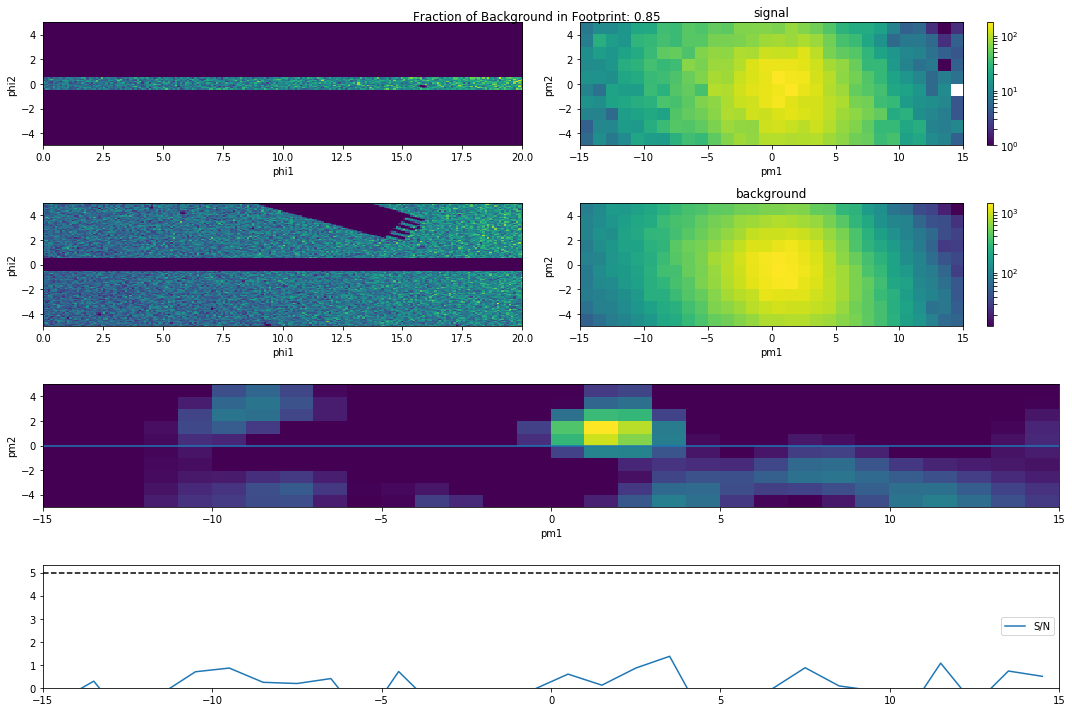

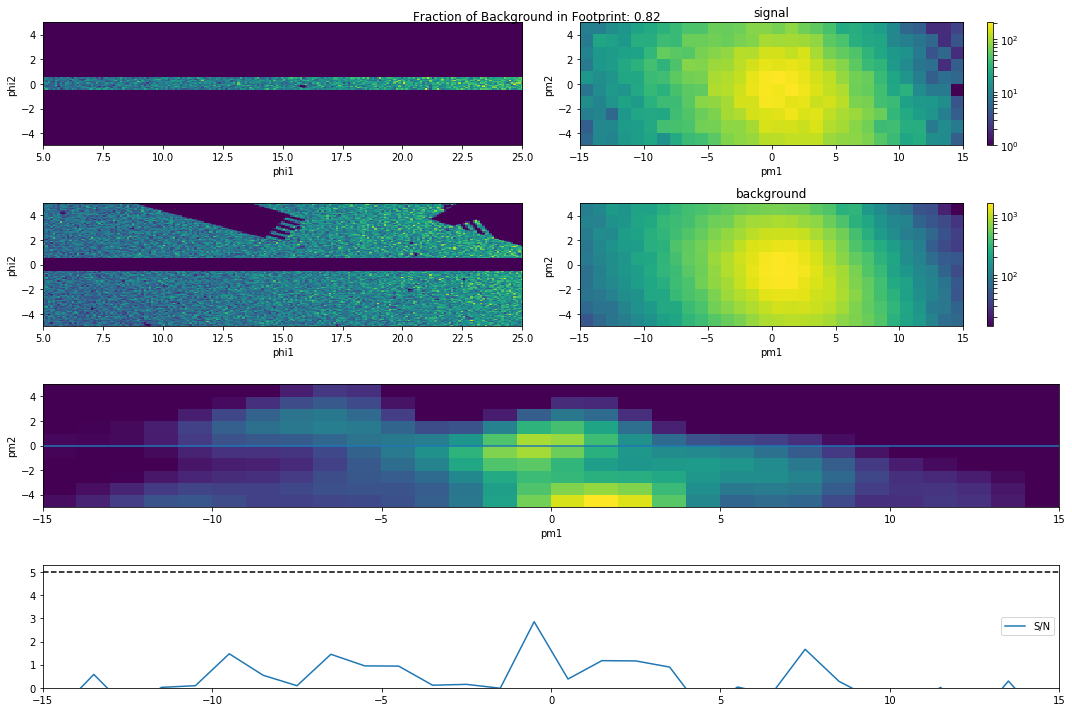

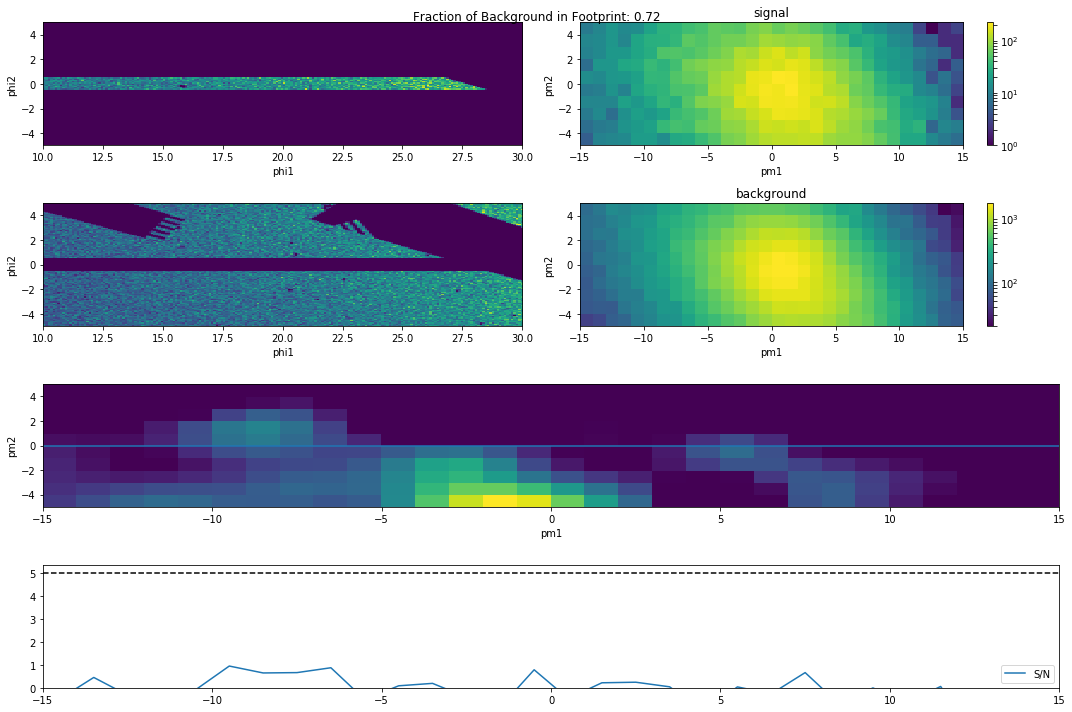

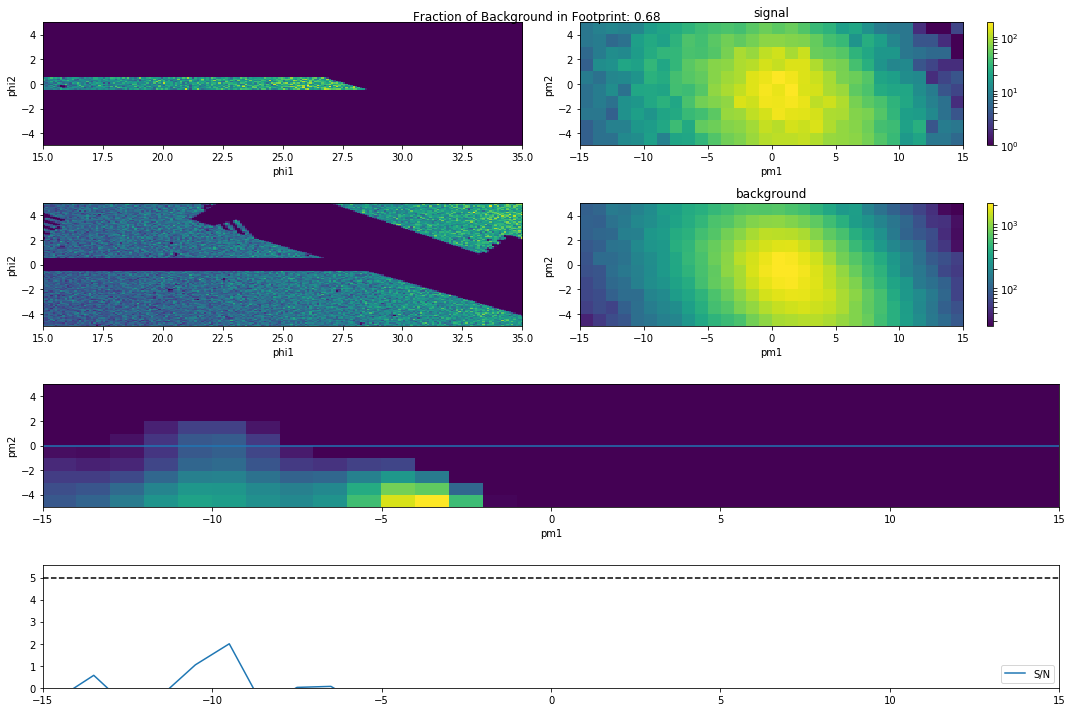

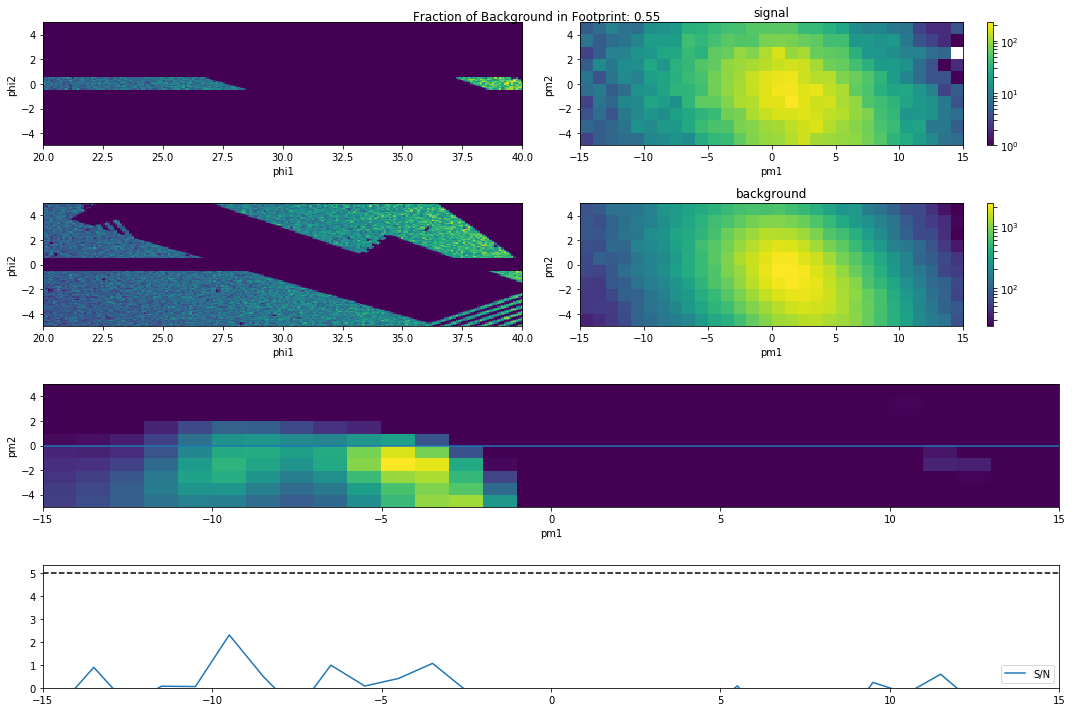

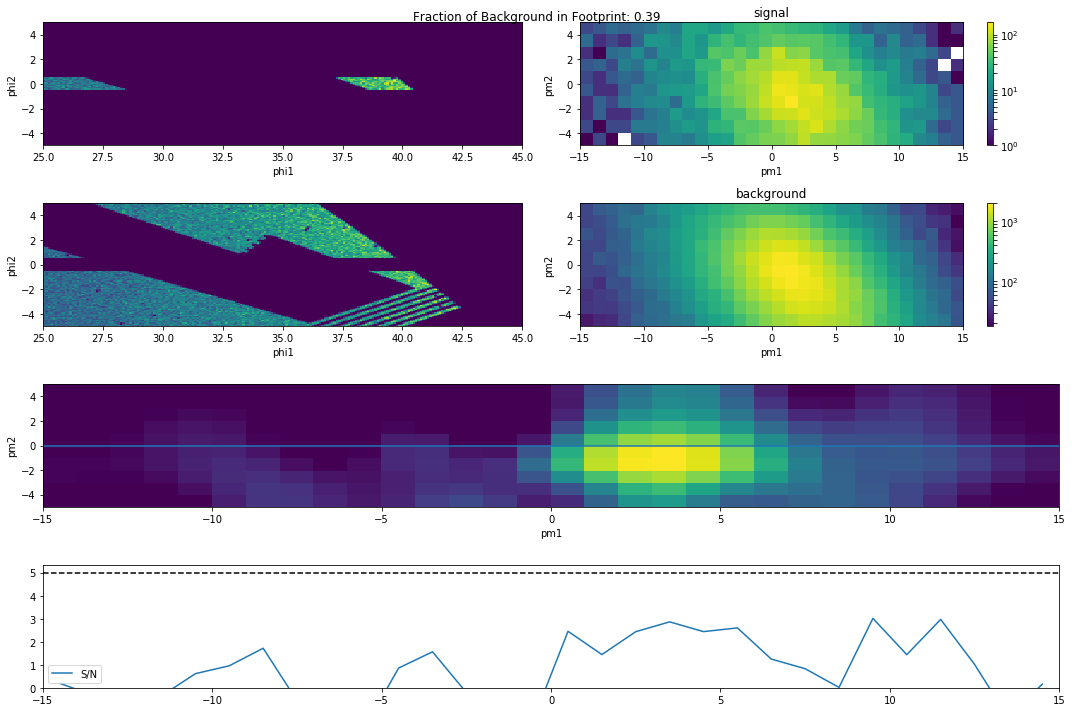

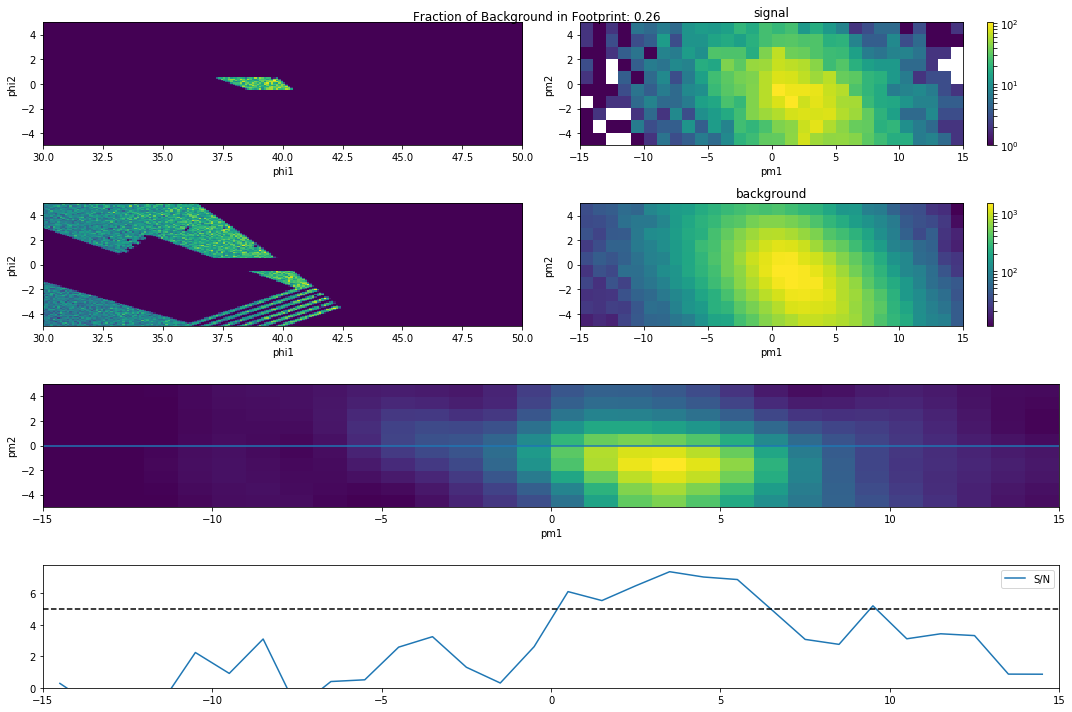

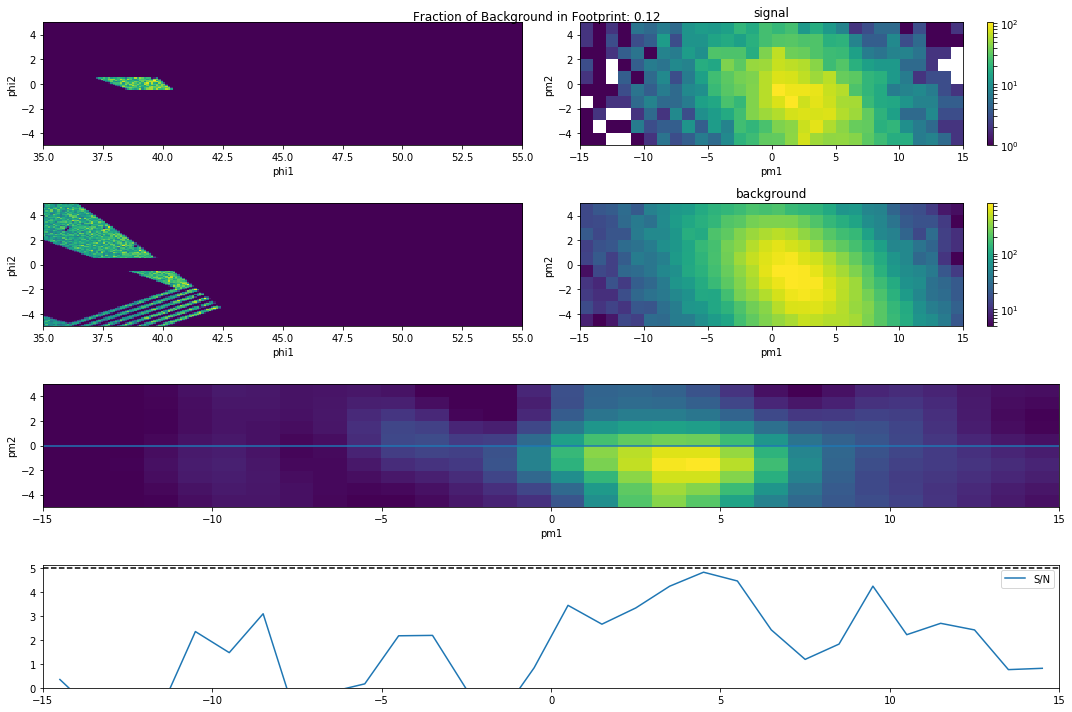

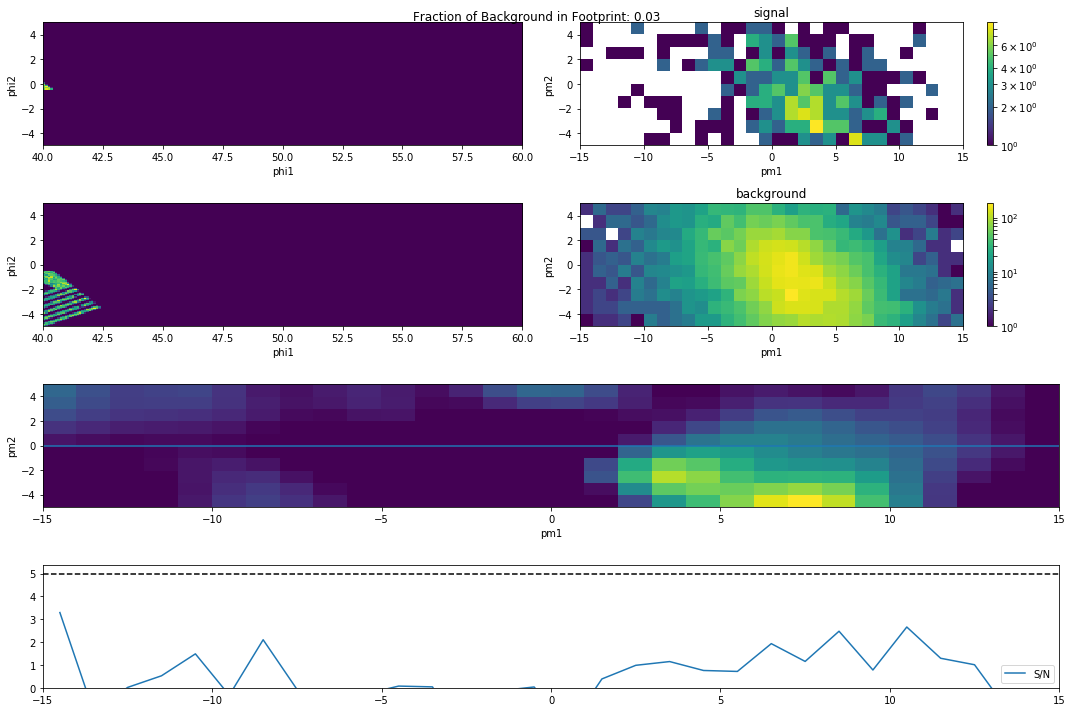

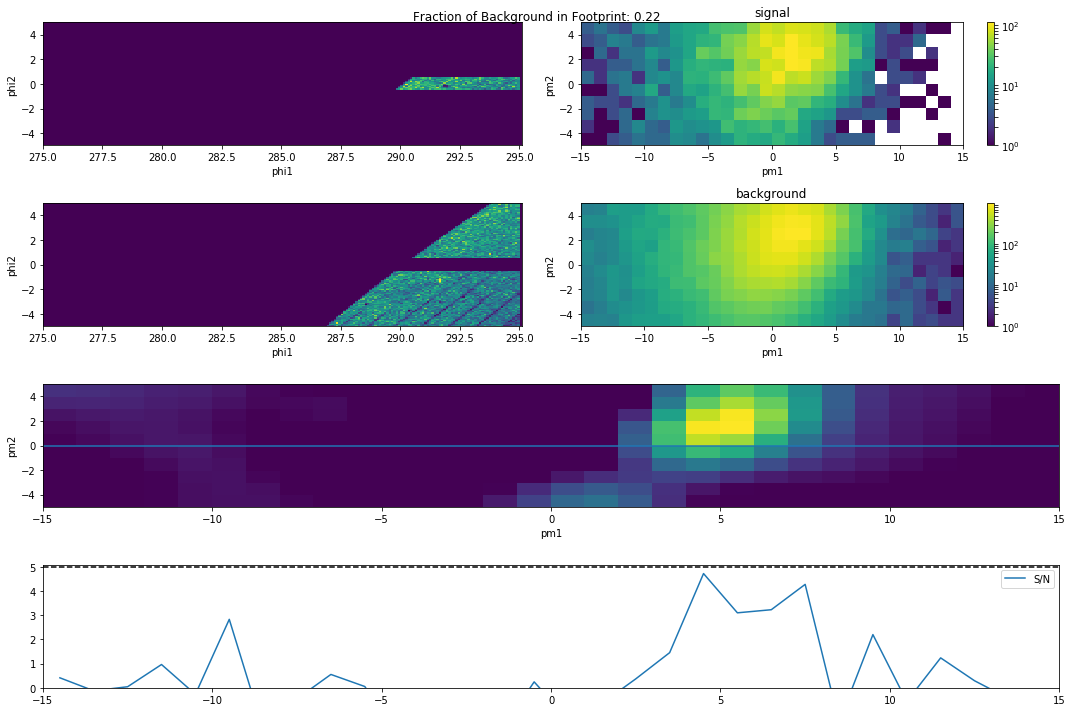

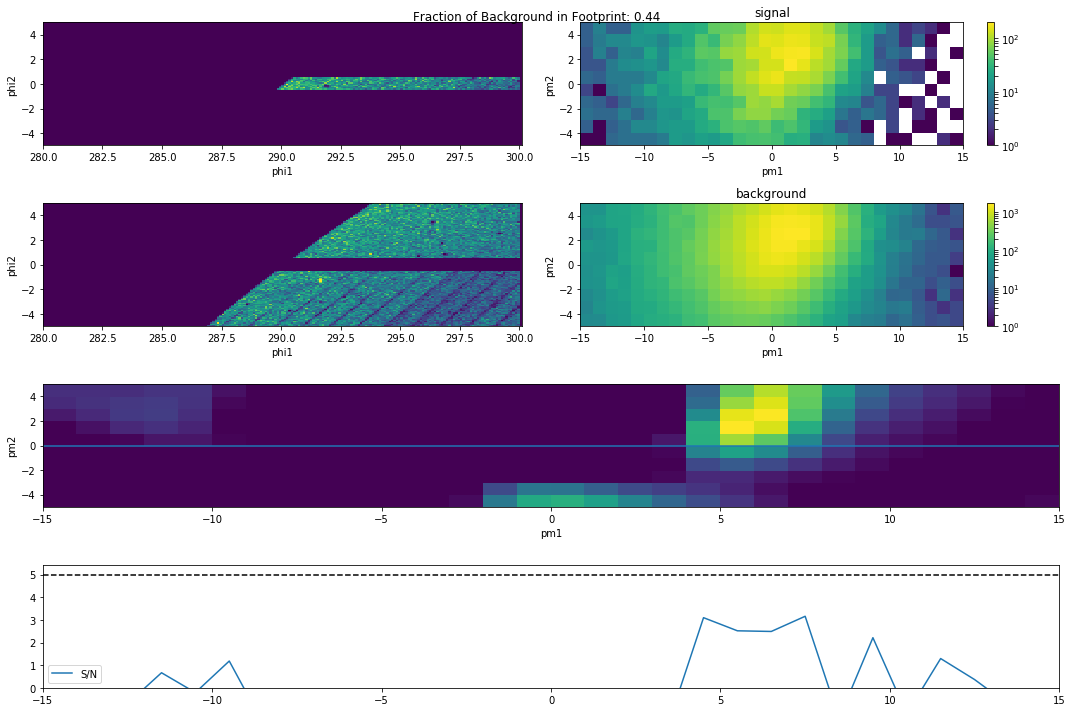

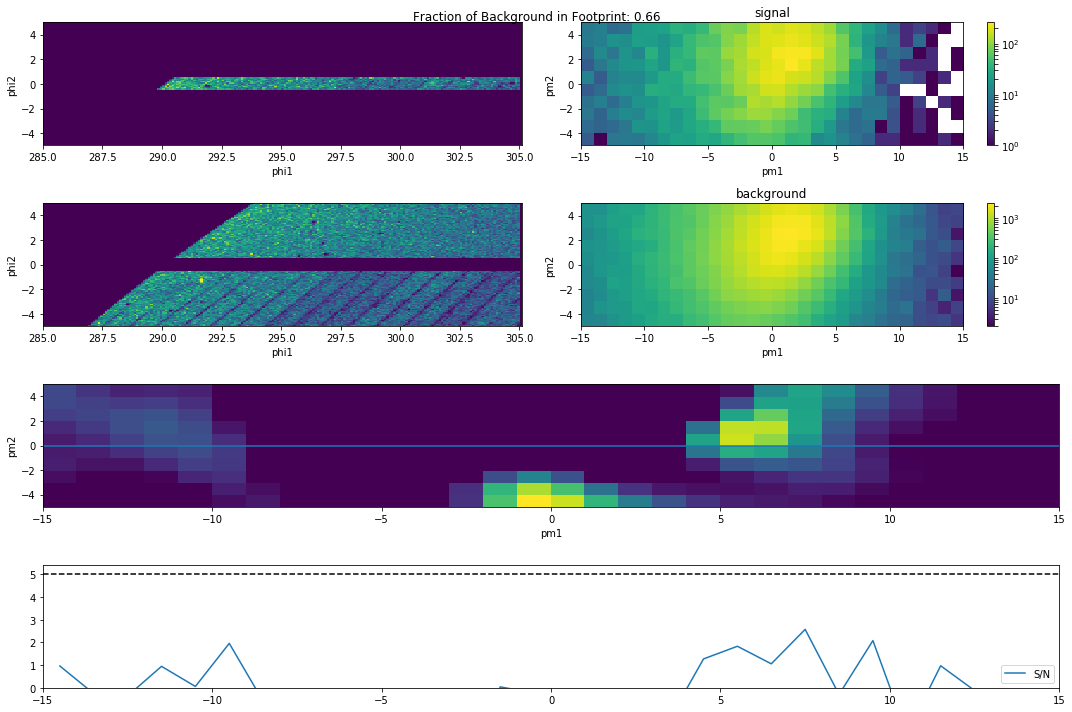

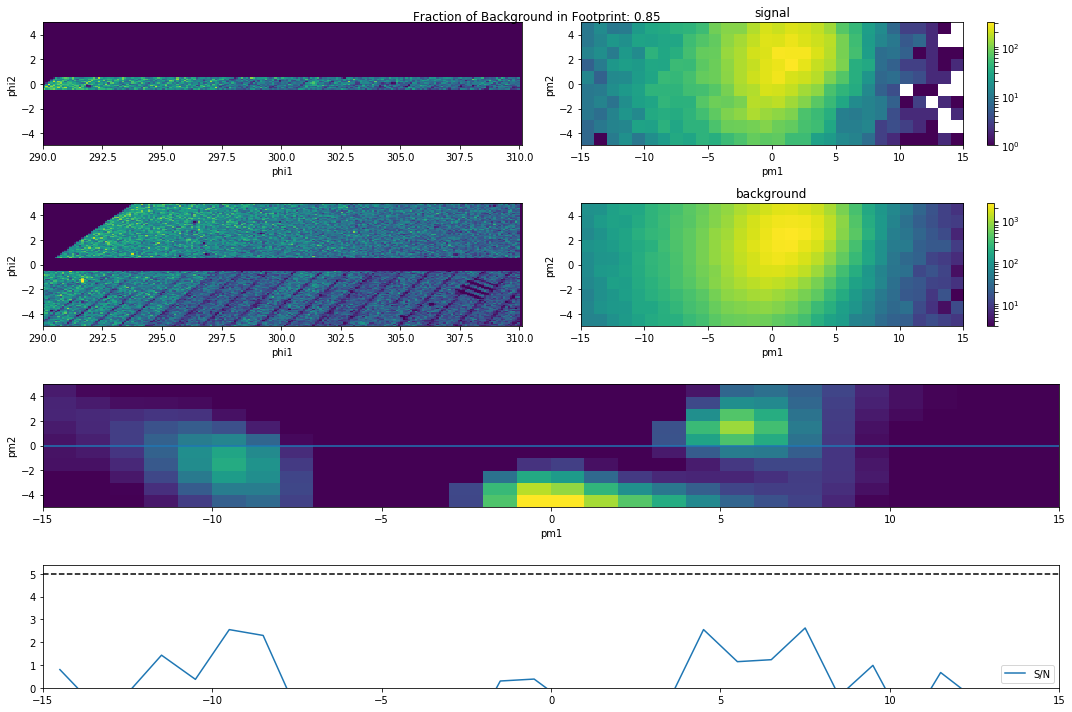

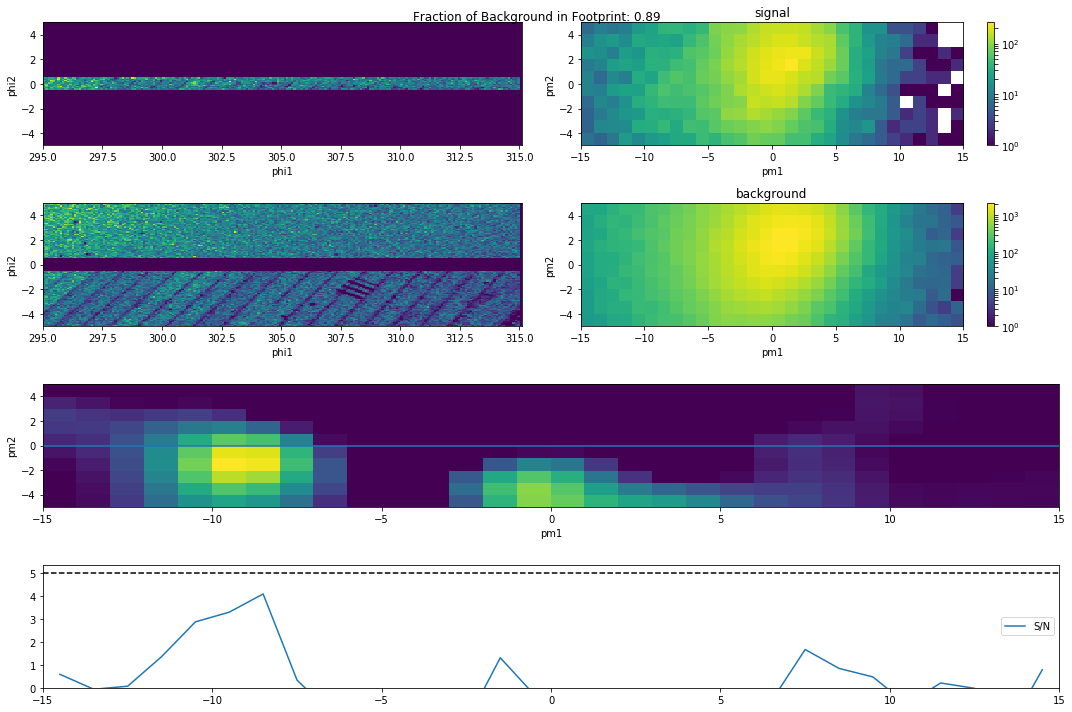

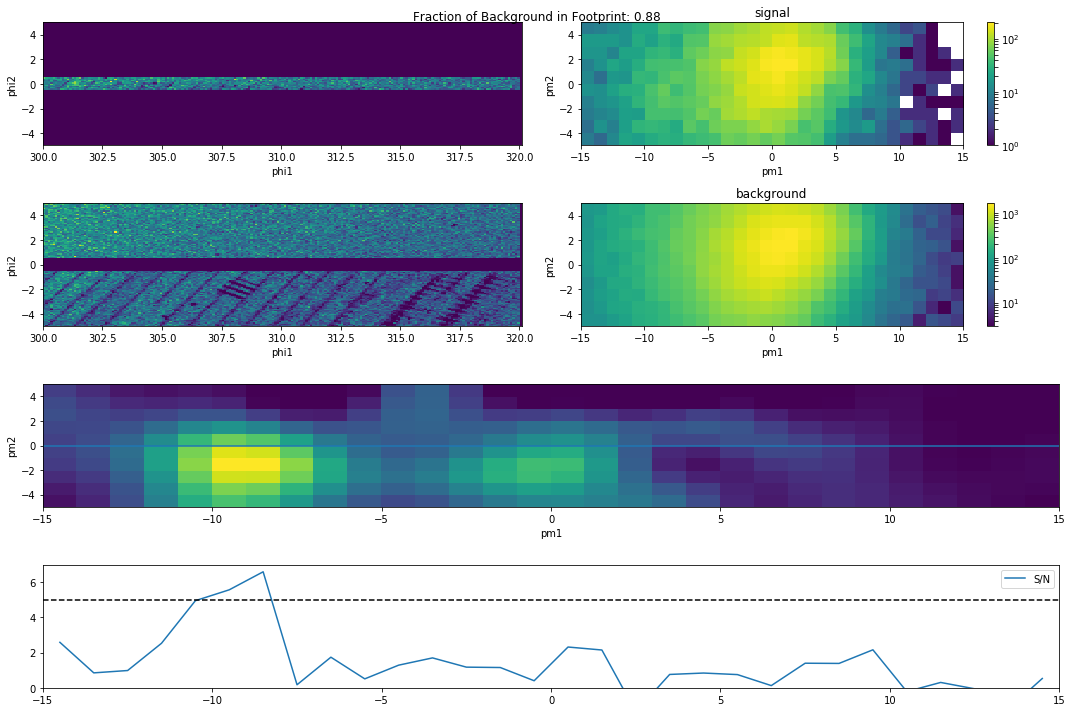

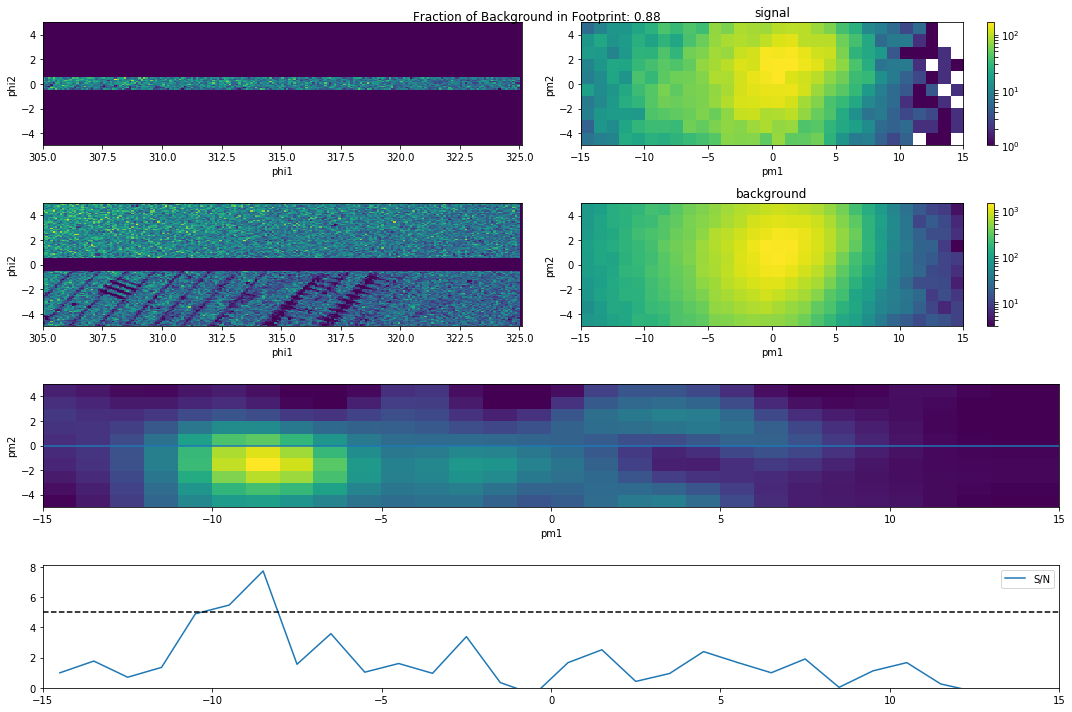

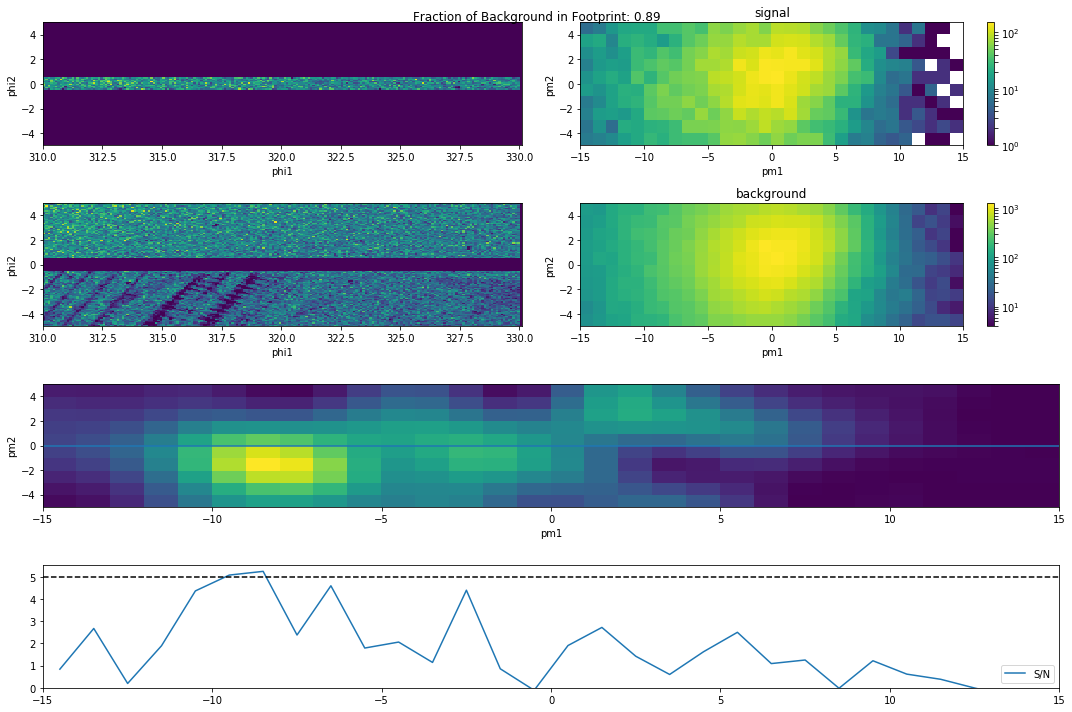

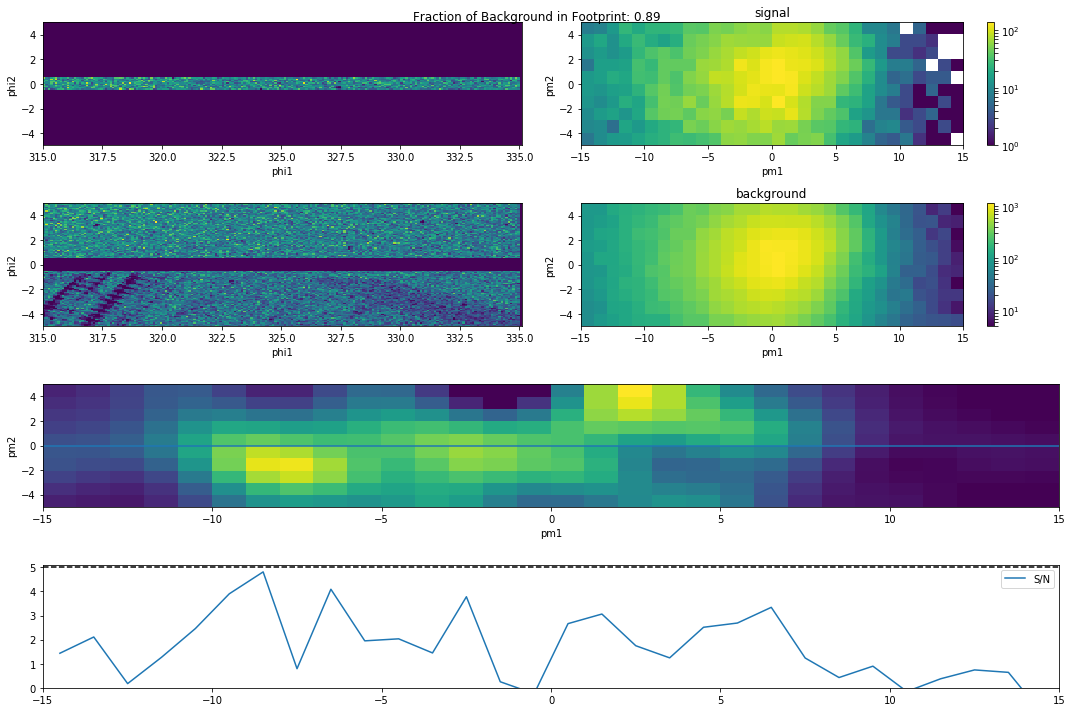

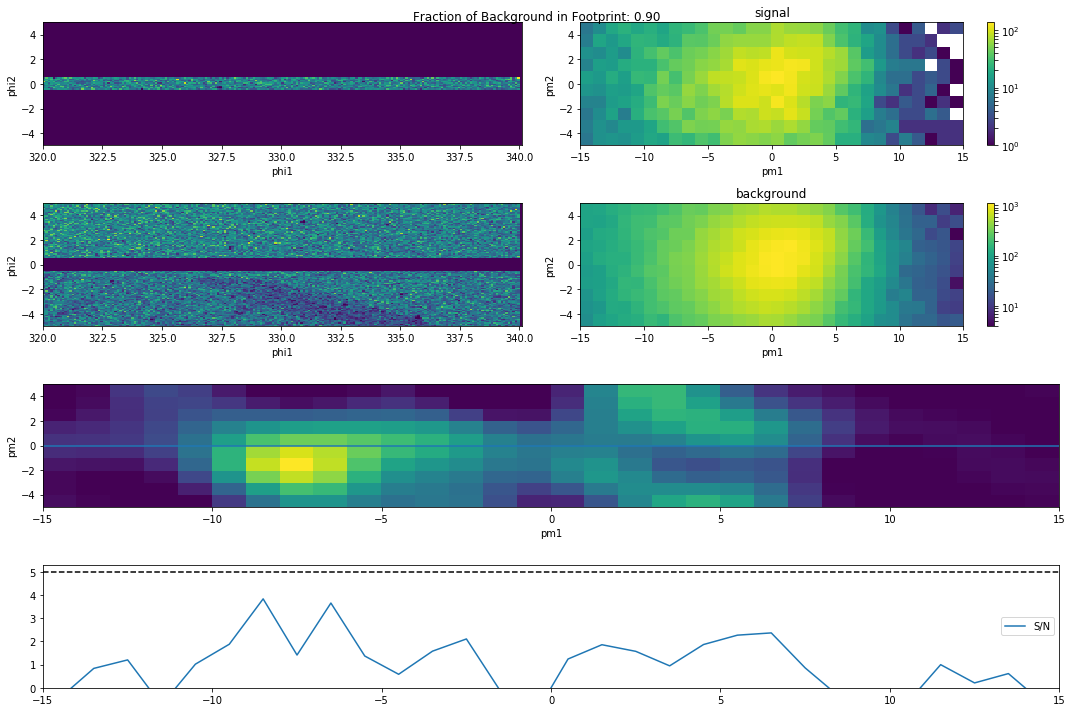

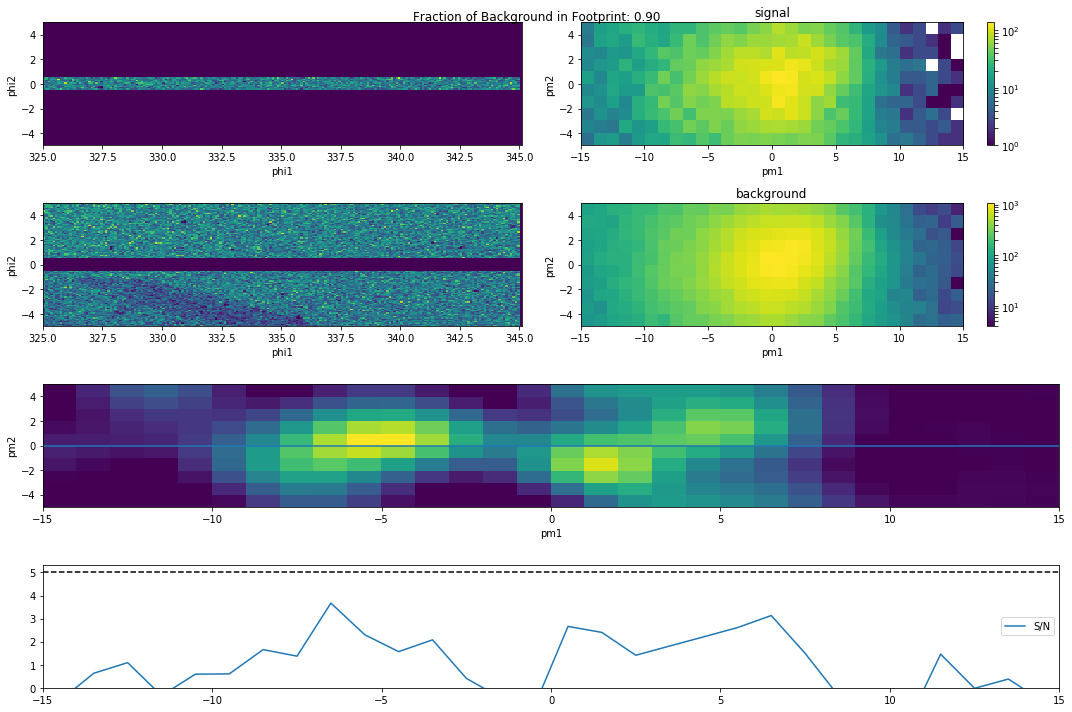

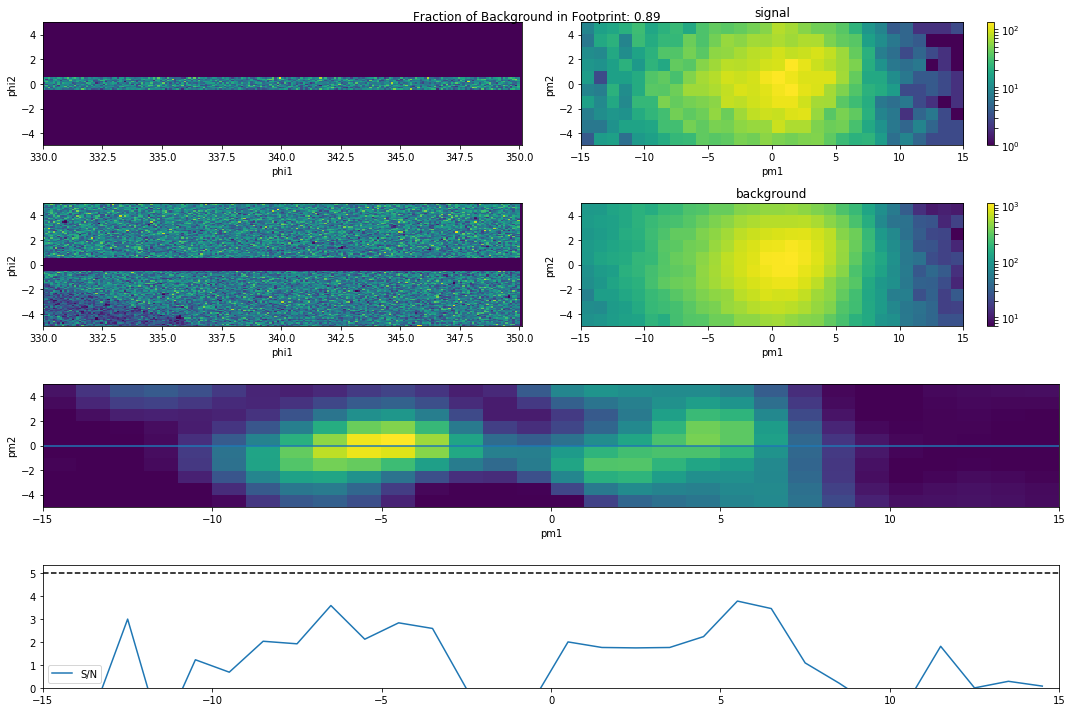

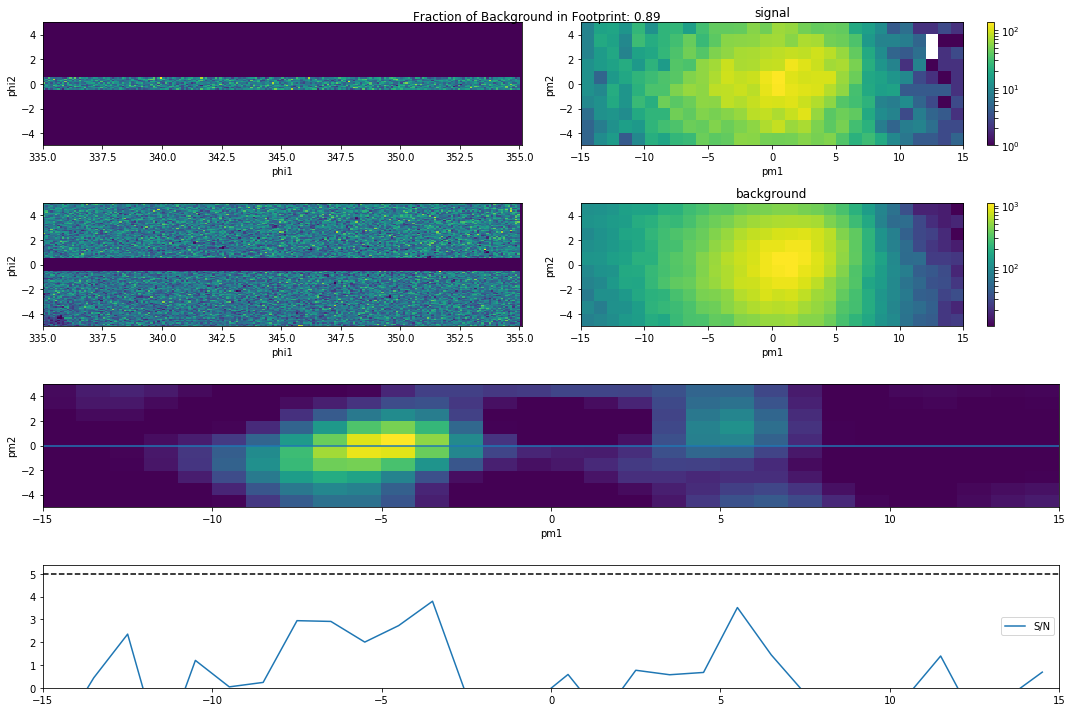

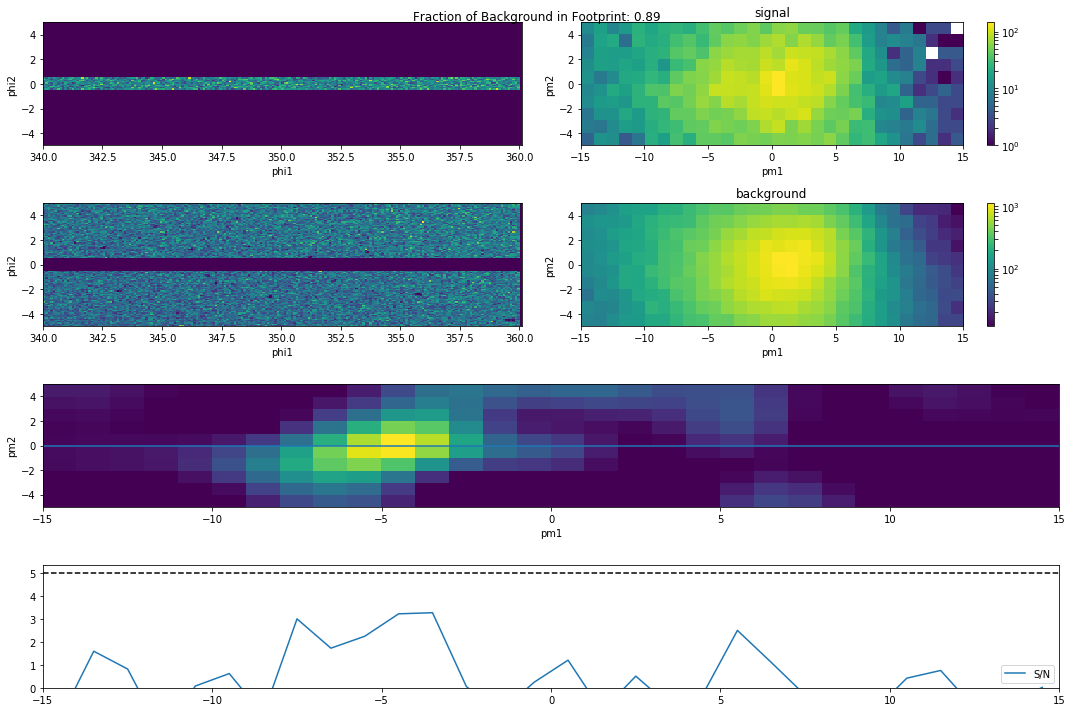

In [ ]:
H, xedges, yedges = np.histogram2d(pmphi1[signal_indices].value,     
                                   pmphi2[signal_indices].value, 
                                   bins=[pm1_edges, pm2_edges])

fig = plt.figure(figsize=(15, 5))
axes = [fig.add_subplot(aa, projection='3d') for aa in [231, 232, 233, 234, 235, 236]]
#ax = fig.gca(projection='3d')
X = (xedges[1:] + xedges[:-1])*0.5
Y = (yedges[1:] + yedges[:-1])*0.5
Z = finalhist.T
X, Y = np.meshgrid(X, Y)
print np.shape(X), np.shape(Y), np.shape(finalhist.T)

for ax, angle in zip(axes, range(0, 360, 60)):
    ax.view_init(20, angle)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-10, cmap=cm.coolwarm)
    #cset = ax.contourf(X, Y, Z, zdir='x', offset=-25, cmap=cm.coolwarm)
    #cset = ax.contourf(X, Y, Z, zdir='y', offset=25, cmap=cm.coolwarm)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.9, zorder=99)
    ax.set_zlim(-10,)

plt.tight_layout()

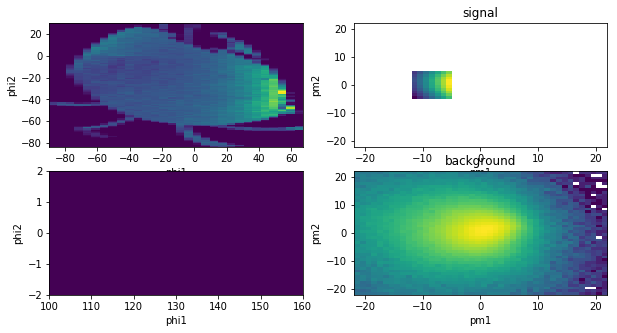

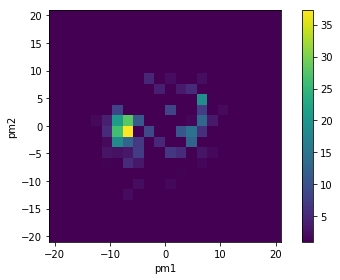

In [212]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
pmphi1min = -12*u.mas/u.yr
pmphi1max = -5*u.mas/u.yr
pmphi2min = -5.0*u.mas/u.yr
pmphi2max = 5.0*u.mas/u.yr


phi2max_b = 5.0*u.deg
phi2min_b = 0.5*u.deg

signal_indices = (pmphi1 >= pmphi1min) & (pmphi1 <= pmphi1max) & \
                 (pmphi2 >= pmphi2min) & (pmphi2 <= pmphi2max)

background_indices 
#background_indices = (pmphi1 >= pmphi1min) & (pmphi1 <= pmphi1max) & \
#                     np.logical_or((pmphi2 >= pmphi2min_b) & (pmphi2 <= pmphi2max_b),
#                                   (pmphi2 >= -pmphi2max_b) & (pmphi2 <= -pmphi2min_b))
  
fig2, ax2 = plt.subplots()
blah = ax2.imshow(finalHist.T, extent=[-21, 21, -21, 21], origin='lower', vmin=1.)#, norm=mpl.colors.LogNorm())
ax2.set_xlabel('pm1')
ax2.set_ylabel('pm2')
plt.colorbar(blah)
ax[0, 0].hist2d(phi1[signal_indices], phi2[signal_indices], bins=[30,100])
for axis in [ax[0, 0], ax[1, 0]]:
    axis.set_xlabel('phi1')
    axis.set_ylabel('phi2')
for axis in [ax[0, 1], ax[1, 1]]:
    axis.set_xlabel('pm1')
    axis.set_ylabel('pm2')
ax[0, 1].hist2d(pmphi1[signal_indices], pmphi2[signal_indices], bins=[pm1_edges, pm2_edges], norm=mpl.colors.LogNorm())
ax[0, 1].set_title('signal')
ax[1, 0].hist2d(phi1[signal_indices], phi2[signal_indices], bins=[10,100], range=[[100, 160], [-2, 2]])
ax[1, 1].hist2d(pmphi1[background_indices], pmphi2[background_indices], bins=[pm1_edges, pm2_edges], norm=mpl.colors.LogNorm())
ax[1, 1].set_title('background')
plt.tight_layout()
fig.savefig('gd1Distributions.png')
fig2.savefig('gd1_pm.png')

In [ ]:
plt.hist2d(phi1[data['psfmag_r'] < 20], phi2[data['psfmag_r'] < 20], bins=1000, norm=mpl.colors.LogNorm())
#plt.ylim(-10, 10)
plt.xlabel('phi 1')
plt.ylabel('phi 2')
plt.title('stars in propermotion cut')
plt.savefig('rotatedFrame.pdf', rasterized=True)

In [233]:
#set up search parameters
#propermotion not perpendicular to the great circle (pmphi2 ~ 0)
#propermotion along great circle < 20 mas/yr
#pmphi1_center = 0.*u.mas/u.yr
#pmphi2_center = 0.*u.mas/u.yr
#pmphi1_width = 5.*u.mas/u.yr
#pmphi2_width = 5.*u.mas/u.yr

pmphi1_edges_right = np.arange(-16, 10.001, 4)*u.mas/u.yr
pmphi1_edges_left = np.arange(-10, 16.001, 4)*u.mas/u.yr
pmphi2_edges = [-5, 5]*u.mas/u.yr #np.arange(-5, 5.0001, 4)*u.mas/u.yr

#search various segmets of phi1
#constrain phi2 to be < 0.25 degrees from great circle
deltaphi1_search = 5.*u.deg #shift of phi1 when searching 
deltaphi2_bin = 0.1*u.deg        #width of bins when fitting for signal and background

phi1_width = deltaphi1_search*3. #width of phi1 for search
phi2_width = 0.5*u.deg          #width of phi2, close to equator
phi1_left_edges = np.arange(0., 360., deltaphi1_search.value)*u.deg
phi1_right_edges = phi1_left_edges + phi1_width
phi1_centers = (phi1_right_edges + phi1_left_edges)/2.
for x in [phi1_centers, phi1_right_edges]:
    x[x > 360.*u.deg] =  x[x > 360.*u.deg] - 360.*u.deg
phi2_center = 0.*u.deg           #equator

background_center = 0.*u.deg     #center of background filter
background_widthmax = 5.*u.deg   #maximum extent to calculate background
background_widthmin = phi2_width #minimum extent for background, exclude signal 

signalbins = np.arange(-phi2_width.value, phi2_width.value+0.0001, deltaphi2_bin.value)*u.deg
signalcenters = (signalbins[1:]+signalbins[:-1])/2.

backgroundbins_low  = np.arange(-background_widthmax.value, -background_widthmin.value+0.0001, deltaphi2_bin.value)*u.deg 
backgroundbins_high = np.arange(background_widthmin.value,   background_widthmax.value+0.0001, deltaphi2_bin.value)*u.deg
backgroundcenters_low = (backgroundbins_low[1:]+backgroundbins_low[:-1])/2.
backgroundcenters_high = (backgroundbins_high[1:]+backgroundbins_high[:-1])/2.

allbins = np.arange(-background_widthmax.value, background_widthmax.value+0.0001, deltaphi2_bin.value)*u.deg
allcenters = (allbins[1:] + allbins[:-1])/2.

0
The detection is 5.61 at pm phi1 -16.00 mas / yr pm phi2 -5.00 mas / yr and phi1 120.00 deg
The detection is 5.25 at pm phi1 -16.00 mas / yr pm phi2 -5.00 mas / yr and phi1 125.00 deg
The detection is 4.00 at pm phi1 -16.00 mas / yr pm phi2 -5.00 mas / yr and phi1 210.00 deg
1
The detection is 7.43 at pm phi1 -12.00 mas / yr pm phi2 -5.00 mas / yr and phi1 115.00 deg
The detection is 10.28 at pm phi1 -12.00 mas / yr pm phi2 -5.00 mas / yr and phi1 120.00 deg
The detection is 9.60 at pm phi1 -12.00 mas / yr pm phi2 -5.00 mas / yr and phi1 125.00 deg
The detection is 5.56 at pm phi1 -12.00 mas / yr pm phi2 -5.00 mas / yr and phi1 130.00 deg
The detection is 4.62 at pm phi1 -12.00 mas / yr pm phi2 -5.00 mas / yr and phi1 185.00 deg
The detection is 5.94 at pm phi1 -12.00 mas / yr pm phi2 -5.00 mas / yr and phi1 210.00 deg
2
The detection is 7.02 at pm phi1 -8.00 mas / yr pm phi2 -5.00 mas / yr and phi1 120.00 deg
The detection is 8.03 at pm phi1 -8.00 mas / yr pm phi2 -5.00 mas / yr and

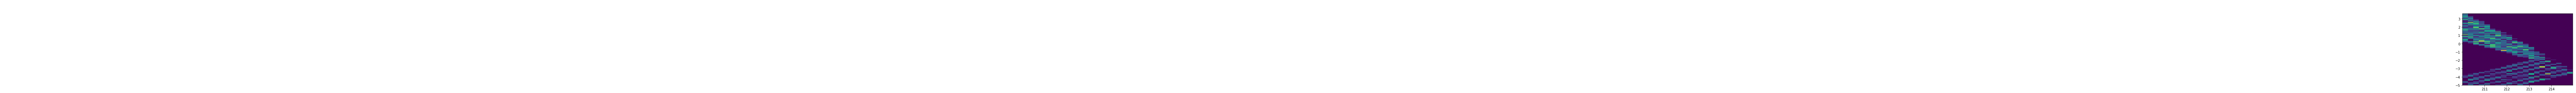

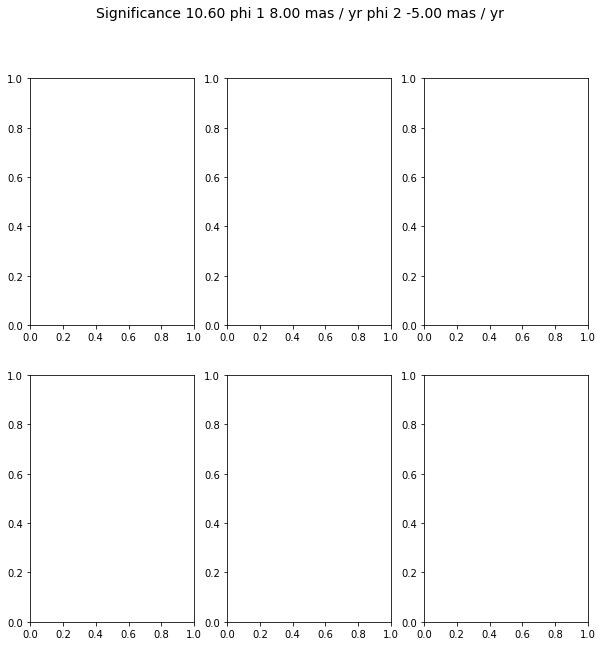

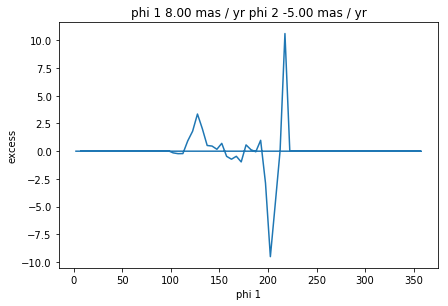

In [244]:

figAll, axesAll = plt.subplots()
fig, axes = plt.subplots(2, 3, figsize=(10,10))
fig2, axes2 = plt.subplots()
axes = axes.flatten()
excessCurrent = np.zeros(len(phi1_right_edges))
excess = np.zeros((len(pmphi1_edges)-1, len(pmphi2_edges)-1))
for j, (pm1_l, pm1_r) in enumerate(zip(pmphi1_edges_right, pmphi1_edges_left)):
    print j
    for k, (pm2_l, pm2_r) in enumerate(zip(pmphi2_edges[:-1], pmphi2_edges[1:])):
        pmindices = (pmphi1 > pm1_l) & (pmphi1 <= pm1_r) &\
                    (pmphi2 > pm2_l) & (pmphi2 <= pm2_r)
        axes2.cla()
        for i, (l, r) in enumerate(zip(phi1_left_edges, phi1_right_edges)): #np.unique(phi1bins):

            #for i, l, r in zip([24], [phi1_left_edges[24]], [phi1_right_edges[24]]):
            for a in axes: a.cla()
            #search for over densities of stars along equator in Phi1 delta degree increments
            #stream is Phi2 = +-0.25 degrees from equator
            #background is Phi2 = +-2 degrees excluding stream 
            deltaPhi2 = phi2 - phi2_center

            posindices  = (phi1 >= l) & \
                          (phi1 <  r) & \
                          (np.abs(deltaPhi2) <= phi2_width) & pmindices
            if np.sum(posindices):
                notindices = (phi1 >= l) & \
                              (phi1 <  r) & \
                              (np.abs(deltaPhi2) <= background_widthmax) & ~pmindices

                notindices2 = (phi1 >= l) & \
                              (phi1 <  r) & \
                              (np.abs(deltaPhi2) <= phi2_width) & ~pmindices
        
                backindices_low = (phi1 >= l) & \
                              (phi1 <  r) & \
                              (deltaPhi2 > -background_widthmax) & \
                              (deltaPhi2 < -background_widthmin) & pmindices
                backindices_high = (phi1 >= l) & \
                              (phi1 <  r) & \
                              (deltaPhi2 < background_widthmax) & \
                              (deltaPhi2 > background_widthmin) & pmindices
                allindices = (phi1 >= l) & \
                              (phi1 <  r) & \
                              (np.abs(deltaPhi2) <= background_widthmax) & pmindices
                axesAll.hist2d(phi1[allindices], phi2[allindices], bins=[20, 100])

                signal, bins_edges = np.histogram(phi2[posindices], bins=signalbins)
                background_low, bin_edges = np.histogram(phi2[backindices_low], bins=backgroundbins_low)
                background_high, bin_edges = np.histogram(phi2[backindices_high], bins=backgroundbins_high)
                background_2, bin_edges = np.histogram(phi2[notindices], bins=allbins)
                background_2 = background_2*np.sum(allindices)/np.float(np.sum(notindices))
                bcfit = np.hstack((backgroundcenters_low, backgroundcenters_high))
                bsfit = np.hstack((background_low.astype('float64'), background_high.astype('float64')))
                p3_2 = np.poly1d(np.polyfit(allcenters, background_2, 3))
                p3 = np.poly1d(np.polyfit(bcfit, bsfit, 3))
                excessCurrent[i] = np.sum(signal - p3(signalcenters))/np.sqrt(np.sum(p3(signalcenters)))
                if excessCurrent[i] > 4.:
                    #backgroundcenters = backgroundcenters[background > 0]
                    #background = background[background > 0]
                    axes[0].hist(phi2[allindices], bins=allbins, histtype='step', normed=True)
                    axes[0].hist(phi2[notindices], bins=allbins, histtype='step', normed=True)
                    #axes[0].hist(phi2[notindices2], bins=allbins, histtype='step', normed=True)
                    axes[0].set_xlabel('phi 2')
                    axes[0].set_ylabel('hist sig and back')
                    axes[1].hist(phi2[posindices], bins=signalbins, histtype='step')
                    axes[1].set_xlabel('phi2')
                    axes[1].set_ylabel('hist of sig')
                    axes[2].hist(phi2[backindices_low], bins=backgroundbins_low, histtype='step')
                    axes[2].hist(phi2[backindices_high], bins=backgroundbins_high, histtype='step')
                    axes[2].set_xlabel('phi 2')
                    axes[2].set_ylabel('hist of back')
                    #cs = scint.CubicSpline(bcfit, bsfit)
                    #cs = scint.UnivariateSpline(bcfit, bsfit, s=0.001)

                    axes[3].hist(phi2[allindices], bins = allbins, label='hist', histtype='step')
                    axes[3].plot(allcenters, p3(allcenters), label='fit')
                    axes[4].plot(allcenters, p3(allcenters), label='fit')
                    axes[3].plot(allcenters, p3_2(allcenters), label='~pm')
                    axes[4].plot(allcenters, p3_2(allcenters), label='~pm')
                    axes[3].legend()
                    axes[4].hist(phi2[backindices_low], bins=backgroundbins_low, label='hist', histtype='step')
                    axes[4].hist(phi2[backindices_high], bins=backgroundbins_high, label='hist', histtype='step')
                    #axes[4].plot(allcenters, cs(allcenters), label='fit')
                    axes[4].set_xlabel('phi 2')
                    axes[4].set_ylabel('fit to back')
                    axes[4].legend()
                    axes[5].hist(phi2[posindices], bins=signalbins, label='hist', histtype='step')
                    axes[5].plot(signalcenters, p3(signalcenters), label='fit')
                    #print signalcenters
                    #print cs(signalcenters)
                    axes[5].set_xlabel('phi 2')
                    axes[5].set_ylabel('fit to sig')
                    axes[5].legend()
                    #signal = signal.astype('float64') - p3(signalcenters)
                    print 'The detection is {0:0.2f} at pm phi1 {1:0.2f} pm phi2 {2:0.2f} and phi1 {3:0.2f}'.format(excessCurrent[i], pm1_l, pm2_l, l)
                    plt.tight_layout()
                    fig.suptitle("Significance {0:0.2f} phi 1 {1:0.2f} phi 2 {2:0.2f}".format(excessCurrent[i], pm1_l, pm2_l), fontsize=14)
                    fig.savefig('fitBackground_{0:03d}_{1:03d}_{2:03d}'.format(j, k, i))
        if np.sum(excessCurrent > 4) > 0: 
            axes2.plot(phi1_centers[~np.isnan(excessCurrent)], excessCurrent[~np.isnan(excessCurrent)])
            axes2.set_xlabel('phi 1')
            axes2.set_ylabel('excess')
            axes2.set_title('phi 1 {0:0.2f} phi 2 {1:0.2f}'.format(pm1_l, pm2_l))
            fig2.savefig('excess_{0:03d}_{1:03d}'.format(j, k))
        excess[j, k] = np.max(excessCurrent)

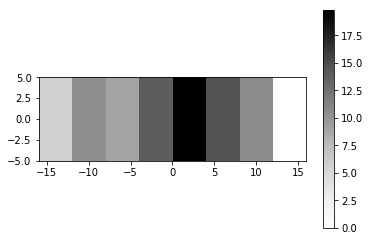

In [235]:
plt.imshow(excess.T, extent=[-16, 16, -5, 5], origin='lower', cmap='Greys')
plt.colorbar()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in double_scalars


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in sqrt


nan
-4.03672576257
-0.57494196406
-2.17735673867
-1.86714992993
-3.25290580232
-1.30387616825
-2.34782017858
-0.80274726887
-1.09639659404
-0.808189021264
-2.40822441086
-2.83751168121
-3.49161768666
-3.76376073845
-2.26161605967
-1.48099192511
0.610911298224
1.30490895527
1.30002579498
1.33771092803
2.99167801192
2.89757485534
3.82336597414
6.90267019849
7.43381527886
8.08303013503
7.6364978059
6.80356328742
5.75825781852
6.17373168362
4.80030812915
4.79878662896
3.42467702322
2.0062852672
0.772657276765
0.102361652887
-0.644320915213
0.118652365069
-0.0148835743238
-1.1138185258
-1.25388847277
-1.49248851396
-1.05495207489
-0.491364585983
-0.92457255529
-0.581105834469
-0.171124605291
-0.219240454303
-0.192336359414
1.74721161517
1.67955982591
1.15146027999
0.651273858189
1.03471490681
0.607331739683
1.26462172988
2.36133317631
3.81240109462
3.28603032242
2.97665155913
2.77457337429
2.51694747433
1.45187333986
1.11292406159
1.96341909587
1.65028323305
-0.294884078634
-0.556819692538


ValueError: Image size of 71678x884 pixels is too large. It must be less than 2^16 in each direction.

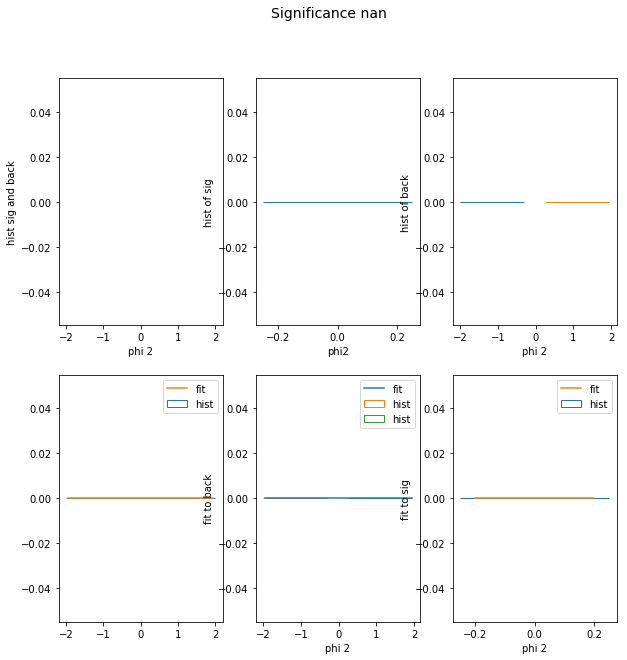

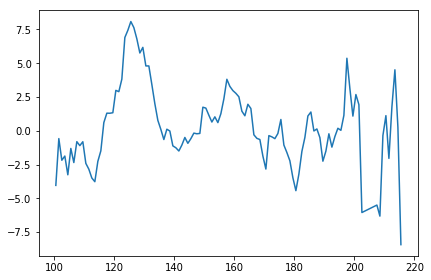

In [42]:
figAll, axesAll = plt.subplots()
fig, axes = plt.subplots(2, 3, figsize=(10,10))
fig2, axes2 = plt.subplots()
axes = axes.flatten()
excess = np.zeros(len(phi1_right_edges))
for i, (l, r) in enumerate(zip(phi1_left_edges, phi1_right_edges)): #np.unique(phi1bins):
#for i, l, r in zip([24], [phi1_left_edges[24]], [phi1_right_edges[24]]):
    for a in axes: a.cla()
    #search for over densities of stars along equator in Phi1 delta degree increments
    #stream is Phi2 = +-0.25 degrees from equator
    #background is Phi2 = +-2 degrees excluding stream 
    deltaPhi2 = phi2 - phi2_center
    
    posindices  = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (np.abs(deltaPhi2) <= phi2_width) & pmindices
            
    notindices = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (np.abs(deltaPhi2) <= background_widthmax) & ~pmindices
            
    backindices_low = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (deltaPhi2 > -background_widthmax) & \
                  (deltaPhi2 < -background_widthmin) & pmindices
    backindices_high = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (deltaPhi2 < background_widthmax) & \
                  (deltaPhi2 > background_widthmin) & pmindices
    allindices = (phi1 >= l) & \
                  (phi1 <  r) & \
                  (np.abs(deltaPhi2) <= background_widthmax) & pmindices
    axesAll.hist2d(phi1[allindices], phi2[allindices], bins=[20, 100])

    signal, bins_edges = np.histogram(phi2[posindices], bins=signalbins)
    background_low, bin_edges = np.histogram(phi2[backindices_low], bins=backgroundbins_low)
    background_high, bin_edges = np.histogram(phi2[backindices_high], bins=backgroundbins_high)
    #backgroundcenters = backgroundcenters[background > 0]
    #background = background[background > 0]
    axes[0].hist(phi2[allindices], bins=allbins, histtype='step', normed=True)
    axes[0].hist(phi2[notindices], bins=allbins, histtype='step', normed=True)
    axes[0].set_xlabel('phi 2')
    axes[0].set_ylabel('hist sig and back')
    axes[1].hist(phi2[posindices], bins=signalbins, histtype='step')
    axes[1].set_xlabel('phi2')
    axes[1].set_ylabel('hist of sig')
    axes[2].hist(phi2[backindices_low], bins=backgroundbins_low, histtype='step')
    axes[2].hist(phi2[backindices_high], bins=backgroundbins_high, histtype='step')
    axes[2].set_xlabel('phi 2')
    axes[2].set_ylabel('hist of back')
    bcfit = np.hstack((backgroundcenters_low, backgroundcenters_high))
    bsfit = np.hstack((background_low.astype('float64'), background_high.astype('float64')))

    p3 = np.poly1d(np.polyfit(bcfit, bsfit, 3))
    #cs = scint.CubicSpline(bcfit, bsfit)
    #cs = scint.UnivariateSpline(bcfit, bsfit, s=0.001)
    
    axes[3].hist(phi2[allindices], bins = allbins, label='hist', histtype='step')
    axes[3].plot(allcenters, p3(allcenters), label='fit')
    axes[4].plot(allcenters, p3(allcenters), label='fit')
    axes[3].legend()
    axes[4].hist(phi2[backindices_low], bins=backgroundbins_low, label='hist', histtype='step')
    axes[4].hist(phi2[backindices_high], bins=backgroundbins_high, label='hist', histtype='step')
    #axes[4].plot(allcenters, cs(allcenters), label='fit')
    axes[4].set_xlabel('phi 2')
    axes[4].set_ylabel('fit to back')
    axes[4].legend()
    axes[5].hist(phi2[posindices], bins=signalbins, label='hist', histtype='step')
    axes[5].plot(signalcenters, p3(signalcenters), label='fit')
    #print signalcenters
    #print cs(signalcenters)
    axes[5].set_xlabel('phi 2')
    axes[5].set_ylabel('fit to sig')
    axes[5].legend()
    #signal = signal.astype('float64') - p3(signalcenters)
    excess[i] = np.sum(signal - p3(signalcenters))/np.sqrt(np.sum(p3(signalcenters)))
    print excess[i]
    plt.tight_layout()
    fig.suptitle("Significance {0:0.2f}".format(excess[i]), fontsize=14)
    fig.savefig('fitBackground_{0:03d}'.format(i))

axes2.plot(phi1_centers[~np.isnan(excess)], excess[~np.isnan(excess)])